# Notebook 3: Target Payoff + Options Optimisation

## 1. Define the downside hedge target payoff curve  
## 2. Build payoff matrix from available option contracts  
## 3. Search for best-fitting put spread  
## 4. Compare target payoff vs chosen structure


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added:", PROJECT_ROOT)


Project root added: c:\Users\nicho\tariff-options-strategy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.tariff_strategy.data.market_data import (
    fetch_price_history,
    list_option_expiries,
    nearest_expiry,
    fetch_options_chain,
    clean_chain,
)

from src.tariff_strategy.trading.target_payoff import (
    build_price_grid,
    downside_target_payoff,
    target_dataframe,
)

from src.tariff_strategy.trading.options_universe import filter_liquid_options
from src.tariff_strategy.trading.put_spread_search import search_best_put_spread
from src.tariff_strategy.trading.payoff import put_payoff


In [3]:
TICKER = "SMH"

prices = fetch_price_history(TICKER, period="6mo")
last = prices["Adj Close"].iloc[-1]
s0 = float(last.iloc[0]) if hasattr(last, "iloc") else float(last)

S_grid = build_price_grid(s0=s0, grid_min=0.60, grid_max=1.40, n=250)

print(f"S0: {s0:.2f}")
print("Grid range:", S_grid.min(), "to", S_grid.max())


S0: 400.39
Grid range: 240.2340087890625 to 560.5460205078125


In [4]:
target = downside_target_payoff(
    S=S_grid,
    s0=s0,
    floor=0.85,  # max payoff below -15%
    cap=1.00,    # starts paying below S0
    scale=1.0
)

target_df = target_dataframe(S_grid, target)
target_df.head()


,S_T,target_payoff
0,240.234009,1.0
1,241.520402,1.0
2,242.806796,1.0
3,244.093190,1.0
4,245.379583,1.0


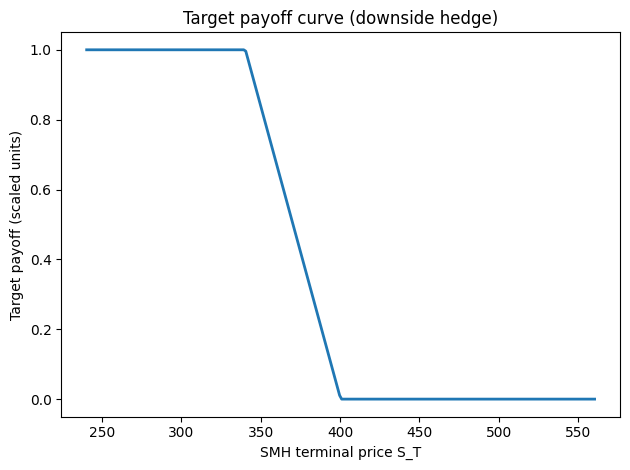

In [5]:
plt.figure()
plt.plot(target_df["S_T"], target_df["target_payoff"], linewidth=2)
plt.title("Target payoff curve (downside hedge)")
plt.xlabel("SMH terminal price S_T")
plt.ylabel("Target payoff (scaled units)")
plt.tight_layout()
plt.show()


In [6]:
TARGET_DAYS = 30

expiries = list_option_expiries(TICKER)
chosen_expiry = nearest_expiry(expiries, target_days=TARGET_DAYS)

chain = clean_chain(fetch_options_chain(TICKER, chosen_expiry))

calls = filter_liquid_options(chain.calls, max_spread=1.00, min_oi=50)
puts = filter_liquid_options(chain.puts, max_spread=1.00, min_oi=50)

print("Chosen expiry:", chosen_expiry)
print("Calls after filters:", len(calls))
print("Puts after filters:", len(puts))
puts.head()


Chosen expiry: 2026-02-13
Calls after filters: 5
Puts after filters: 12


,contractSymbol,strike,lastPrice,bid,ask,mid,spread,volume,openInterest,impliedVolatility,inTheMoney
0,SMH260213P00320000,320.0,0.75,0.72,0.88,0.80,0.16,2.0,108,0.478033,False
1,SMH260213P00330000,330.0,1.09,0.94,1.32,1.13,0.38,47.0,208,0.461431,False
2,SMH260213P00335000,335.0,1.34,1.15,1.49,1.32,0.34,12.0,56,0.445074,False
3,SMH260213P00340000,340.0,1.70,1.50,1.72,1.61,0.22,42.0,50,0.430792,False
4,SMH260213P00350000,350.0,2.22,2.16,2.40,2.28,0.24,27.0,149,0.407110,False


In [7]:
# We only optimise over PUT spreads for a tariff-downside hedge
put_meta = puts[["contractSymbol", "strike", "mid"]].copy()

results = search_best_put_spread(
    S_grid=S_grid,
    puts=put_meta.rename(columns={"contractSymbol": "symbol"}),  # align with earlier format
    target=target
)

results.head(10)


,K_long,K_short,cost,error
0,385.0,350.0,577.0,0.003129
1,385.0,340.0,644.0,0.004175
2,385.0,360.0,480.0,0.005541
3,385.0,335.0,673.0,0.005940
4,385.0,365.0,412.5,0.008049
5,385.0,330.0,692.0,0.008326
6,375.0,350.0,332.0,0.008499
7,375.0,360.0,235.0,0.009190
8,385.0,367.5,377.5,0.009618
9,372.5,350.0,284.5,0.010384


Best put spread:
K_long     385.000000
K_short    350.000000
cost       577.000000
error        0.003129
Name: 0, dtype: float64


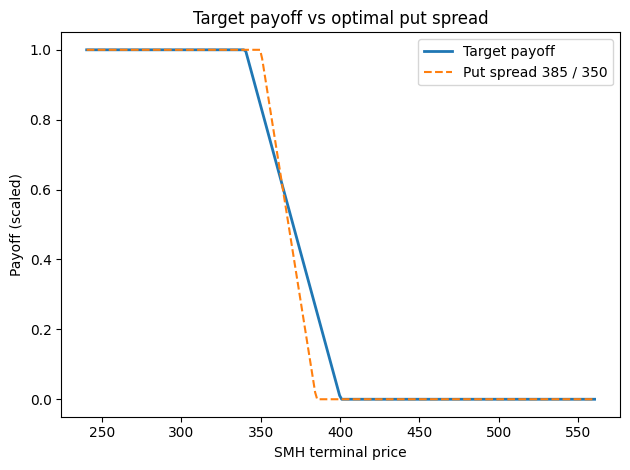

In [8]:
best = results.iloc[0]
K_long = float(best["K_long"])
K_short = float(best["K_short"])
cost = float(best["cost"])

width = K_long - K_short
spread_payoff_scaled = (put_payoff(S_grid, K_long) - put_payoff(S_grid, K_short)) / width

print("Best put spread:")
print(best)

plt.figure()
plt.plot(S_grid, target, label="Target payoff", linewidth=2)
plt.plot(S_grid, spread_payoff_scaled, label=f"Put spread {int(K_long)} / {int(K_short)}", linestyle="--")
plt.legend()
plt.xlabel("SMH terminal price")
plt.ylabel("Payoff (scaled)")
plt.title("Target payoff vs optimal put spread")
plt.tight_layout()
plt.show()


In [9]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

best_out = pd.DataFrame([best])
best_out["chosen_expiry"] = chosen_expiry
best_out["S0"] = s0

best_out.to_csv(DATA_DIR / "notebook3_best_put_spread.csv", index=False)
target_df.to_csv(DATA_DIR / "notebook3_target_payoff.csv", index=False)

print("Saved:")
print("-", DATA_DIR / "notebook3_best_put_spread.csv")
print("-", DATA_DIR / "notebook3_target_payoff.csv")


Saved:
- data\notebook3_best_put_spread.csv
- data\notebook3_target_payoff.csv
